notes:
- important todos noted with ###todo


sources :
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- deeplearningwizard for model architecture

In [1]:
%pwd

'/Users/Maxine/Desktop/se_corpus/rubrix'

In [2]:
# installations for colab
!pip install skorch
!pip install modal

In [125]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

import webbrowser
import rubrix as rb
from modAL.models import ActiveLearner

## Data

In [41]:
"""
load data: specify path
"""

# 1) (index), text, label
initial_train = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # macbook
# initial_train = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) #imac
# initial_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
initial_train.drop(columns=['text'], inplace = True)

dev = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-dev.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
# dev = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-dev.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
# dev = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/es_ancora-ud-dev.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
dev.drop(columns=['text'], inplace = True)

test = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
# test = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
# test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/es_ancora-ud-test.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
test.drop(columns=['text'], inplace = True)

# by fileting out 'se'-sentences the data split of the initial ud corpus isn't accurate anymore
se_corpus = pd.concat([initial_train, dev, test])

pool = pd.read_csv('/Users/Maxine/Desktop/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # macbook
# pool = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # imac
# pool = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/sp_text_se_corpus.txt', names=['text'], sep='\t')

# Note: for some reason jupyter cannot find the relative path

In [42]:
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'flat')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'fixed')].index)
se_corpus.shape

(4248, 2)

In [43]:
"""
data split
"""
X = se_corpus.tokenized_text
y = se_corpus.se_label

# Split into train+val and test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train and val
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1, stratify=y, random_state=21)

In [44]:
"""
check label distribution in splits
"""
def get_class_dist(y_set):
    data = y_set.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')


In [45]:
"""
store value counts for making weighted data sets
"""
y_train_counter = dict(y_train.value_counts())

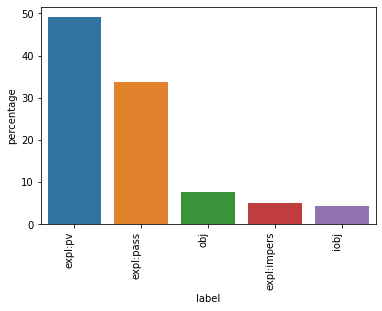

In [46]:
get_class_dist(y_train)

In [47]:
"""
eventually implement fasttext word embeddings instead of CountVectorizer()
"""
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # todo change to es
# ft = fasttext.load_model('cc.en.300.bin') # rename model

'\neventually implement fasttext word embeddings instead of CountVectorizer()\n'

In [48]:
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_dev = vectorizer.transform(X_dev).toarray()
X_test = vectorizer.transform(X_test).toarray()

pool_vectorized = vectorizer.transform(pool.text).toarray()

y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)


In [49]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


In [50]:
class PoolDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [53]:
train_set = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
dev_set = ClassifierDataset(torch.from_numpy(X_dev).float(), torch.from_numpy(y_dev).long())
test_set = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

pool_set = PoolDataset(torch.from_numpy(pool_vectorized).float())

In [54]:
"""
assign bigger weight to less frequent labels
"""
target_list = torch.tensor([target for _, target in train_set])
class_count = [label for label in y_train_counter.values()]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
print('label distribution: ', y_train_counter.items(), '\nassigned weights: ', class_weight)

label distribution:  dict_items([('expl:pv', 1502), ('expl:pass', 1032), ('obj', 232), ('expl:impers', 157), ('iobj', 135)]) 
assigned weights:  tensor([0.0007, 0.0010, 0.0043, 0.0064, 0.0074])


In [55]:
"""
assign weight to each sample in the train set
"""
class_weight_all = class_weight[target_list]
weighted_sampler = WeightedRandomSampler(weights=class_weight_all, num_samples=len(class_weight_all), replacement=True)

In [56]:
train_loader = DataLoader(dataset=train_set, batch_size=64, sampler=weighted_sampler)
dev_loader = DataLoader(dataset=dev_set, batch_size=32)
test_loader = DataLoader(dataset=test_set, batch_size=32)

In [ ]:
# """
# Data wrangling
# 1. Reading data from torchvision
# 2. Assembling initial training data for ActiveLearner
# 3. Generating the pool
# """
#
# dataloader = DataLoader(se_corpus, shuffle=True, batch_size=60000)
# X, y = next(iter(dataloader))
# X = X.detach().cpu().numpy() # TF not recognized by learner
# y = y.detach().cpu().numpy()
#
# # read training data
# X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000], y[50000:]
# X_train = X_train.reshape(50000, 1, 28, 28)
# X_test = X_test.reshape(10000, 1, 28, 28)
#
# # assemble initial data
# n_initial = 1000
# initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
# X_initial = X_train[initial_idx]
# y_initial = y_train[initial_idx]
#
# # generate the pool
# # remove the initial data from the training dataset
# X_pool = np.delete(X_train, initial_idx, axis=0)
# y_pool = np.delete(y_train, initial_idx, axis=0)

## Model

In [57]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = 64

        # Number of hidden layers
        self.layer_dim = 1

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(16325, 64, 1, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(64, 5)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [113]:
# build class for the skorch API
# class Torch_Model(nn.Module):
#     def __init__(self,):
#         super(Torch_Model, self).__init__()
#         self.convs = nn.Sequential(
#                                 nn.Conv2d(1,32,3),
#                                 nn.ReLU(),
#                                 nn.Conv2d(32,64,3),
#                                 nn.ReLU(),
#                                 nn.MaxPool2d(2),
#                                 nn.Dropout(0.25)
#         )
#         self.fcs = nn.Sequential(
#                                 nn.Linear(12*12*64,128),
#                                 nn.ReLU(),
#                                 nn.Dropout(0.5),
#                                 nn.Linear(128,10),
#         )
#
#     def forward(self, x):
#         out = x
#         out = self.convs(out)
#         out = out.view(-1,12*12*64)
#         out = self.fcs(out)
#         return out

In [ ]:
### todo: https://github.com/skorch-dev/skorch/issues/499
### add accuracy callback

In [58]:
"""
skorch library creates sklearn classifier from torch neural net
"""
batch_size = 64
n_iters = 1000 ### todo gpu
epochs = int(n_iters/(len(train_set)/ batch_size))

# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
print('using: ', device)

# Callbacks: print accuracy when model is fitted
train_acc = EpochScoring(scoring='accuracy', on_train=True,
                         name='train_acc', lower_is_better=False)
callbacks = [train_acc]

classifier = NeuralNetClassifier(module=LSTMModel,
                                 batch_size=64,
                                 max_epochs= epochs,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.SGD,
                                 lr=0.1,
                                 train_split=None,
                                 callbacks=callbacks,
                                 verbose=1,
                                 device=device)

using:  cpu


In [59]:
"""
LSTM need 3-D input: determine shape and reshape
- train
- pool
"""
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 16325])
Labels batch shape: torch.Size([64])


In [60]:
#reshaping to rows, timestamps, features
train_features = torch.reshape(train_features,   (train_features.shape[0], 1,train_features.shape[1]))
print(f"Feature batch shape: {train_features.size()}")

Feature batch shape: torch.Size([64, 1, 16325])


In [118]:
# do the same for the test data which is going to be used in the active learning loop
test_features, test_labels = next(iter(test_loader))
test_features = torch.reshape(test_features,   (test_features.shape[0], 1,test_features.shape[1]))

Feature batch shape: torch.Size([32, 1, 16325])


In [61]:
# do the same for the data pool which is going to be used in the active learning loop
X_pool = pool_set.X_data
X_pool = torch.reshape(X_pool,   (X_pool.shape[0], 1, X_pool.shape[1]))
X_pool = X_pool.detach().cpu().numpy()

Feature batch shape: torch.Size([12579, 1, 16325])


In [63]:
"""
fit the skorch classifier with the training data instead of leaving fitting to the ActiveLearner() (which would expect different shapes for the input data, would be incompatible with LSTM)
"""
classifier.fit(train_features, train_labels)

  epoch    train_loss     dur
-------  ------------  ------
      1        1.6747  0.0414
      2        1.6695  0.0377
      3        1.6644  0.0292
      4        1.6592  0.0283
      5        1.6542  0.0275
      6        1.6491  0.0307
      7        1.6441  0.0311
      8        1.6392  0.0288
      9        1.6342  0.0301
     10        1.6294  0.0278
     11        1.6245  0.0314
     12        1.6197  0.0285
     13        1.6149  0.0368
     14        1.6101  0.0316
     15        1.6054  0.0535
     16        1.6007  0.0335
     17        1.5960  0.0385
     18        1.5914  0.0276
     19        1.5868  0.0295
     20        1.5822  0.0320


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(16325, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=5, bias=True)
  ),
)

## Active Learner

In [64]:
"""
Initialize the ActiveLearner with the fitted classifier
"""
learner = ActiveLearner(
    estimator=classifier
)

In [65]:
n_instances = 10
accuracies = []

### Loop

In [120]:
# query instances and predicted probs
query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
probabilities = learner.predict_proba(X_pool[query_idx])

In [67]:
# record probs and retrieve text string for annotation
records = [rb.TextClassificationRecord(
    id=idx,
    inputs=pool.text.iloc[idx],
    prediction=list(zip(['expl:pass', 'obj', 'expl:impers', 'iobj', 'expl:pv'], probs)),
    prediction_agent="skorch_classifier", # purpose: keep track of 'who' did predictions
    )
    for idx, probs in zip(query_idx, probabilities)
]

rb.log(records, name="pytorch_active_learning_se_corpus")

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/pytorch_active_learning_se_corpus


BulkResponse(dataset='pytorch_active_learning_se_corpus', processed=10, failed=0)

In [122]:
# compare annotated label with the predicted label
records_df = rb.load("pytorch_active_learning_se_corpus", ids=query_idx.tolist(), as_pandas=False)
annotation = [record.annotation for record in records_df]

if None in annotation:
    # discard sentences that should not be in the corpus and delete index of sentences
    print('Note: you either discarded samples or did not annotate all of them')
    discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample is None]
    discarded_idxs = sorted(discarded_idxs, reverse=True)
    for index in discarded_idxs:
        query_inst = np.delete(query_inst, index, axis=0)
    annotation = list(filter(None.__ne__, annotation))

y_pool = label_encoder.transform(annotation)

# train the classifier with the newly annotated examples
learner.teach(query_inst, y_pool)  # query_inst == X_pool[query_idx]
accuracies.append(learner.score(X=test_features, y=test_labels))  # Keep track of our improvement

X_pool = np.delete(X_pool, query_idx, axis=0)

Note: you either discarded samples or did not annotate all of them
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        1.6012  0.0257
      2        1.5992  0.0267
      3        1.5972  0.0159
      4        1.5952  0.0155
      5        1.5932  0.0148
      6        1.5912  0.0149
      7        1.5893  0.0145
      8        1.5873  0.0205
      9        1.5854  0.0153
     10        1.5834  0.0185
     11        1.5815  0.0215
     12        1.5796  0.0191
     13        1.5777  0.0187
     14        1.5758  0.0165
     15        1.5740  0.0210
     16        1.5721  0.0175
     17        1.5703  0.0187
     18        1.5684  0.0165
     19        1.5666  0.0158
     20        1.5648  0.0185


In [ ]:
"""
### todo: update while loop
"""
# while len(accuracies) < 20:
# while len(accuracies) < 2:
#     query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
#     probabilities = learner.predict_proba(X_pool[query_idx])
#     records = [
#     rb.TextClassificationRecord(
#         id=idx,
#         inputs=pool.text.iloc[idx],
#         prediction=list(zip(['expl:pass', 'obj', 'expl:impers', 'iobj', 'expl:pv'], probs)),
#         prediction_agent="skorch_classifier", # purpose: keep track of 'who' did predictions
#     )
#     for idx, probs in zip(query_idx, probabilities)
# ]
#
#     # Log the records
#     rb.log(records, name="pytorch_active_learning_se_corpus")
#     webbrowser.get('firefox').open_new_tab('http://0.0.0.0:6900')
#
#     input('confirm that annotations on rubrix are finished')
#     records_df = rb.load("pytorch_active_learning_se_corpus", ids=query_idx.tolist(), as_pandas=False)
#     annotation = [record.annotation for record in records_df]
#     if 'None' in annotation: # make it possible to discard sentences that should not be in the corpus
#         print('you either discarded samples or did not annotate all of them')
#         annotation = list(filter('None'.__ne__, annotation))
#
#     y_pool = label_encoder.transform(annotation)  # train the classifier with the newly annotated examples
#     learner.teach(query_inst, y_pool)  # query_inst == X_pool[query_idx]
#     accuracies.append(learner.score(X=X_test, y=y_test))  # Keep track of our improvement
#     X_pool = np.delete(X_pool, query_idx, axis=0)  # remove queried instances from pool

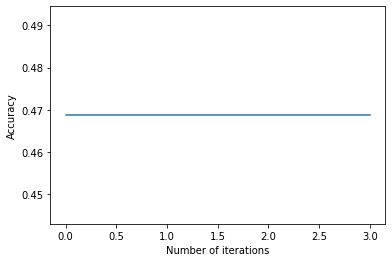

In [128]:
# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");